### Analyse et comprehension des fichiers

In [1]:
import matplotlib.pyplot as plt
from h_index.src.read_data import *
from h_index.src.utils import *
import csv
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

In [ ]:
data1 = data.sample(n=10,random_state=1)
ids = data1.iloc[0,:]['author']
paper_id_dic = get_authors_papers_id_by_ids([ids])
abstract = get_abstracts_by_dic(paper_id_dic)
abstract

In [306]:
def df_to_txt(data,file_name):
    data[['hindex_lab','text']].to_csv(file_name,index=False,sep=' ',header = None, quoting=csv.QUOTE_NONE,quotechar="", escapechar= " ")
def getText(dic):
    temp = [""]*dic['IndexLength']
    for word, pos in dic["InvertedIndex"].items():
        for i in pos:
            temp[i] = word
    return " ".join((filter((None).__ne__, temp)))

def get_abstracts_by_dic(dic):
    ids = dic.keys()
    abstracts_file = open("../data/abstracts.txt", "r",encoding="utf-8")
    abstracts ={}
    for i,line in enumerate(abstracts_file):
        id, data = line.split("----",1)
        if(int(id) in ids):
            abstracts[dic[int(id)]] = [json.loads(data)] if abstracts.get(dic[int(id)]) is None else [json.loads(data)]+abstracts.get(dic[int(id)])
    return abstracts

def get_authors_papers_id_by_ids(ids):
    author_papers_file = open("../data/author_papers.txt", "r",encoding="utf-8")
    author_papers = {}
    for line in author_papers_file:
        author_id, papers_string = line.split(":")
        if(int(author_id) in ids):
            papers_ids = papers_string.split("-")
            for paper_id in papers_ids:
                author_papers[int(paper_id)] = int(author_id)
    return author_papers

def preprocessing_for_fastText(n_sample,data):
    data1 = data.sample(n=n_sample,random_state=1)
    ids = data1['author'].to_list()
    paper_id_dic = get_authors_papers_id_by_ids(ids)
    abstract = get_abstracts_by_dic(paper_id_dic)
    abstract_text = {}
    for id in abstract.keys() :
        abstract_text[id] = " ".join(simple_preprocess(" ".join([" ".join(r['InvertedIndex']) for r in abstract[id]])))
    data1['hindex_lab'] = data1['hindex'].apply(lambda x:'__label__'+str(x))
    df_abstract_text = pd.DataFrame.from_dict(abstract_text,orient = 'index',columns=['text'])
    df_abstract_text["author"] = df_abstract_text.index
    df_abstract_text= df_abstract_text.reset_index(drop=True)
    df_data = data1.merge(df_abstract_text,left_on="author",right_on="author",how="inner")
    return df_data

def preprocessing2_for_fastText(n_sample,data,k):
    maxi = data['hindex'].max()
    data['modindx'] = data['hindex'].apply(lambda x:x if x<k else k)
    data1 = data.sample(n=n_sample,random_state=1)
    ids = data1['author'].to_list()
    paper_id_dic = get_authors_papers_id_by_ids(ids)
    abstract = get_abstracts_by_dic(paper_id_dic)
    abstract_text = {}
    for id in abstract.keys() :
        abstract_text[id] = " ".join(simple_preprocess(" ".join([getText(r) for r in abstract[id]])))
    data1['hindex_lab'] = data1['modindx'].apply(lambda x:'__label__'+str(x))
    df_abstract_text = pd.DataFrame.from_dict(abstract_text,orient = 'index',columns=['text'])
    df_abstract_text["author"] = df_abstract_text.index
    df_abstract_text= df_abstract_text.reset_index(drop=True)
    df_data = data1.merge(df_abstract_text,left_on="author",right_on="author",how="inner")
    return df_data
def general_comp(model,test):
    test_pred = model.predict(test['text'].to_list())
    test_pred_lab = [t[0] for t in test_pred[0]]
    test_pred_prob = [t[0] for t in test_pred[1]]
    df_test_pred = pd.DataFrame({"test_pred_lab":test_pred_lab,"test_pred_prob":test_pred_prob})
    test = test.reset_index(drop = True)  
    test_comp = pd.concat([df_test_pred,test],axis=1)
    test_err=test_comp[test_comp['hindex_lab']!=test_comp['test_pred_lab']]
    return test_err


**distriubution des données**

In [133]:
train,n_train = get_train_data()
test,n_test = get_test_data()

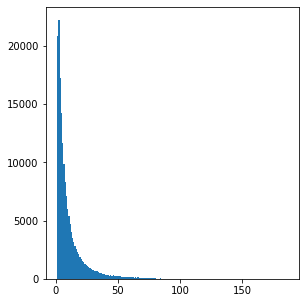

In [139]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train['hindex'],bins=187);

**selection of sub-dataset with same distribution than the original**

In [280]:
data = preprocessing2_for_fastText(10000,train,6)


In [250]:
data.describe()

,author,hindex,modindx
count,4.912000e+03,4912.000000,4912.000000
mean,1.993429e+09,9.953787,4.399023
std,6.460106e+08,12.226329,1.882840
min,1.139156e+07,1.000000,1.000000
25%,2.018736e+09,3.000000,3.000000
50%,2.135585e+09,6.000000,6.000000
75%,2.292421e+09,12.000000,6.000000
max,2.908001e+09,160.000000,6.000000


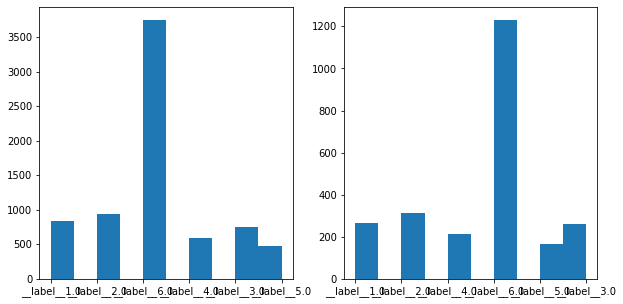

In [281]:
train1,test1 = train_test_split(data,random_state=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train1['hindex_lab'])
plt.subplot(1,2,2).hist(test1['hindex_lab']);

In [282]:
df_to_txt(train1,"train2.txt")
df_to_txt(test1,"test2.txt")

### Utilisation de Fast text

In [83]:
%cd ../../fastText-0.9.2/
%pip install 
%cd ../h_index/src/

d:\Projets\data challenge inf 554\fastText-0.9.2


In [12]:
import fasttext

In [ ]:
help(fasttext.FastText)

In [283]:
model0 = fasttext.train_supervised("train2.txt")

In [285]:
model1 = fasttext.train_supervised("train2.txt",autotuneValidationFile="test2.txt")

In [284]:
model0.test('train2.txt')

(7347, 0.5123179529059481, 0.5123179529059481)

In [288]:
model1.test("train2.txt")

(7347, 0.6167143051585682, 0.6167143051585682)

In [287]:
model1.test('test2.txt')

(2449, 0.5671702735810535, 0.5671702735810535)

In [295]:
model1.predict(data['text'][1],k=7)

(('__label__6.0',
  '__label__3.0',
  '__label__4.0',
  '__label__2.0',
  '__label__5.0',
  '__label__1.0'),
 array([0.61561322, 0.10354131, 0.09084164, 0.08684644, 0.08272073,
        0.02049657]))

In [290]:
data.iloc[0:3,:]

,author,hindex,modindx,hindex_lab,text
0,2192797973,15.0,6.0,__label__6.0,we present newly collected data set of gold st...
1,2568812976,4.0,4.0,__label__4.0,problem to be solved to provide tv system for ...
2,2159374572,24.0,6.0,__label__6.0,this paper presents novel engine coined topx f...


In [297]:
model1.get_nearest_neighbors("hello")

[(1.0, 'mannercovering'),
 (1.0, 'anycasting'),
 (1.0, 'urging'),
 (1.0, 'informationso'),
 (0.9999871850013733, 'bruton'),
 (0.9999871850013733, 'kinobeads'),
 (0.9999871850013733, 'btk'),
 (0.9999871850013733, 'imatinib'),
 (0.9999871850013733, 'actin'),
 (0.9999871850013733, 'transpeptidase')]

In [301]:
comp = pd.DataFrame({'paramètre':['hidden layer','learning rate','epoch','loss'],'model0':[model0.dim,model0.lr,model0.epoch,model0.loss],'model1':[model1.dim,model1.lr,model1.epoch,model1.loss]})
comp

,paramètre,model0,model1
0,hidden layer,100,23
1,learning rate,0.1,0.943793
2,epoch,5,4
3,loss,loss_name.softmax,loss_name.softmax


In [307]:
general_comp(model1,test1)

,test_pred_lab,test_pred_prob,author,hindex,modindx,hindex_lab,text
0,__label__6.0,0.906547,2396441528,1.0,1.0,__label__1.0,temporal and spatial localities are basic conc...
3,__label__1.0,0.336361,2229182562,2.0,2.0,__label__2.0,this paper describes the prototype of conversa...
4,__label__6.0,0.314087,2308460797,4.0,4.0,__label__4.0,the internet of things iot represents the curr...
6,__label__6.0,0.425907,2799533387,1.0,1.0,__label__1.0,castellanii ac are ubiquitously distributed in...
10,__label__1.0,0.548298,2097906641,2.0,2.0,__label__2.0,this manual describes prolog system developed ...
...,...,...,...,...,...,...,...
2435,__label__6.0,0.536444,2471368406,4.0,4.0,__label__4.0,assessing ageing infrastructure is critical ch...
2437,__label__1.0,0.556697,2423342115,3.0,3.0,__label__3.0,existing tourism destination investigations of...
2440,__label__1.0,0.298030,2109819932,3.0,3.0,__label__3.0,with an increasing focus on science and techno...
2441,__label__6.0,0.365446,1988330601,5.0,5.0,__label__5.0,the existence of large api libraries contribut...


**exploitation de model**

In [310]:
dictionnaire = model1.get_words()

In [311]:
dictionnaire

['the',
 'of',
 'and',
 'to',
 'in',
 'is',
 'for',
 'that',
 'we',
 'this',
 'on',
 'with',
 'are',
 'an',
 'as',
 'by',
 'data',
 'be',
 'from',
 'system',
 'based',
 'can',
 'which',
 'paper',
 'or',
 'at',
 'it',
 'using',
 'information',
 'our',
 'model',
 'have',
 'these',
 'such',
 'systems',
 'results',
 'has',
 'time',
 'used',
 'network',
 'one',
 'method',
 'approach',
 'also',
 'new',
 'performance',
 'use',
 'user',
 'their',
 'more',
 '</s>',
 'been',
 'between',
 'not',
 'different',
 'two',
 'analysis',
 'software',
 'present',
 'design',
 'applications',
 'each',
 'first',
 'proposed',
 'was',
 'its',
 'into',
 'high',
 'application',
 'web',
 'show',
 'other',
 'may',
 'process',
 'service',
 'both',
 'algorithm',
 'models',
 'methods',
 'were',
 'control',
 'problem',
 'set',
 'than',
 'well',
 'all',
 'study',
 'when',
 'over',
 'level',
 'provide',
 'large',
 'number',
 'research',
 'image',
 'services',
 'techniques',
 'language',
 'users',
 'order',
 'through',
 

In [315]:
model1.get_word_id("the")

0

In [313]:
len(dictionnaire)

68513

In [316]:
A = model1.get_input_matrix()

In [317]:
A.shape

(68513, 23)

In [318]:
B = model1.get_output_matrix()

In [319]:
B.shape

(6, 23)

In [320]:
from scipy.special import softmax

In [322]:
the = np.zeros(A.shape[0])
the[0] = 1

In [327]:
repthe = the.T @ A
softthe = repthe@B.T
softmax(softthe)

array([2.82518499e-01, 4.63972994e-02, 1.10249079e-04, 1.96739552e-01,
       2.27720037e-01, 2.46514363e-01])

In [ ]:
print